# Group By: split-apply-combine

## Introduction



[Reference](http://pandas.pydata.org/pandas-docs/stable/groupby.html)
* Splitting an object into groups
* Iterating through groups
* Selecting a group
* Aggregation
* Transformation
* Filtration
* Dispatching to instance methods
* Flexible apply
* Other useful features

By “group by” we are referring to a process involving one or more of the following steps
* **Splitting** the data into groups based on some criteria
* **Applying** a function to each group independently
* **Combining** the results into a data structure

In the **apply** step, we might wish to one of the following:
* **Aggregation**: computing a summary statistic (or statistics) about each group. Some examples:
   * Compute group sums or means
   * Compute group sizes / counts
* **Transformation**: perform some group-specific computations and return a like-indexed. Some examples:
   * Standardizing data (zscore) within group
   * Filling NAs within groups with a value derived from each group
* **Filtration**: discard some groups, according to a group-wise computation that evaluates True or False. Some examples:
   * Discarding data that belongs to groups with only a few members
   * Filtering out data based on the group sum or mean
* **Some combination** of the above: GroupBy will examine the results of the apply step and try to return a sensibly combined result if it doesn’t fit into either of the above two categories

See the [cookbook](http://pandas.pydata.org/pandas-docs/stable/cookbook.html#cookbook-grouping) for some advanced strategies

In [1]:
import pandas as pd
import numpy as np
print("Pandas version : {}".format(pd.__version__))
print("Numpy version : {}".format(np.__version__))

Pandas version : 0.22.0
Numpy version : 1.14.3


## Splitting an object into groups

In [2]:
df = pd.DataFrame({'A' : ['foo', 'bar', 'foo', 'bar',
                          'foo', 'bar', 'foo', 'foo'],
                   'B' : ['one', 'one', 'two', 'three',
                          'two', 'two', 'one', 'three'],
                   'C' : np.random.randn(8),
                   'D' : np.random.randn(8)})
df

,A,B,C,D
0,foo,one,-0.530547,-1.088767
1,bar,one,0.228345,-0.014067
2,foo,two,-0.385456,-2.104826
3,bar,three,-1.475673,-2.780173
4,foo,two,0.222049,1.433940
5,bar,two,-0.364773,1.063475
6,foo,one,-1.354189,0.990410
7,foo,three,-1.085772,-0.804856


In [3]:
grouped = df.groupby('A')

In [4]:
grouped.sum()

,C,D
A,,
bar,-1.612101,-1.730765
foo,-3.133915,-1.574099


### GroupBy sorting
By default the group keys are sorted during the `groupby` operation.

In [5]:
df2 = pd.DataFrame({'X' : ['B', 'B', 'A', 'A'], 'Y' : [1, 2, 3, 4]})
df2

,X,Y
0,B,1
1,B,2
2,A,3
3,A,4


In [6]:
df2.groupby(['X']).sum()

,Y
X,
A,7
B,3


In [7]:
df2.groupby(['X'], sort=False).sum()

,Y
X,
B,3
A,7


In [8]:
df3 = pd.DataFrame({'X' : ['A', 'B', 'A', 'B'], 'Y' : [1, 4, 3, 2]})
df3

,X,Y
0,A,1
1,B,4
2,A,3
3,B,2


In [9]:
df3.groupby(['X']).get_group('A')

,X,Y
0,A,1
2,A,3


In [11]:
df3.groupby(['X']).get_group('B')

,X,Y
1,B,4
3,B,2


### GroupBy with MultiIndex

In [12]:
arrays = [['bar', 'bar', 'baz', 'baz', 'foo', 'foo', 'qux', 'qux'],
          ['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two']]
index = pd.MultiIndex.from_arrays(arrays, names=['first', 'second'])
s = pd.Series(np.random.randn(8), index=index)
s

first  second
bar    one       0.155409
       two      -1.338507
baz    one      -1.078239
       two       2.569389
foo    one       0.450666
       two      -0.363592
qux    one      -0.482694
       two       0.107755
dtype: float64

In [13]:
grouped = s.groupby(level=0)
grouped.sum()

first
bar   -1.183098
baz    1.491151
foo    0.087075
qux   -0.374938
dtype: float64

In [14]:
s.groupby(level='second').sum()

second
one   -0.954857
two    0.975046
dtype: float64

## Iterating through groups

In [17]:
df

,A,B,C,D
0,foo,one,-0.530547,-1.088767
1,bar,one,0.228345,-0.014067
2,foo,two,-0.385456,-2.104826
3,bar,three,-1.475673,-2.780173
4,foo,two,0.222049,1.433940
5,bar,two,-0.364773,1.063475
6,foo,one,-1.354189,0.990410
7,foo,three,-1.085772,-0.804856


In [16]:
grouped = df.groupby('A')
for name, group in grouped:
    print(name)
    print(group)

bar
     A      B         C         D
1  bar    one  0.228345 -0.014067
3  bar  three -1.475673 -2.780173
5  bar    two -0.364773  1.063475
foo
     A      B         C         D
0  foo    one -0.530547 -1.088767
2  foo    two -0.385456 -2.104826
4  foo    two  0.222049  1.433940
6  foo    one -1.354189  0.990410
7  foo  three -1.085772 -0.804856


## Selecting a group

In [18]:
grouped.get_group('bar')

,A,B,C,D
1,bar,one,0.228345,-0.014067
3,bar,three,-1.475673,-2.780173
5,bar,two,-0.364773,1.063475


In [19]:
df.groupby(['A', 'B']).get_group(('bar', 'one'))

,A,B,C,D
1,bar,one,0.228345,-0.014067


## Aggregation

In [21]:
df

,A,B,C,D
0,foo,one,-0.530547,-1.088767
1,bar,one,0.228345,-0.014067
2,foo,two,-0.385456,-2.104826
3,bar,three,-1.475673,-2.780173
4,foo,two,0.222049,1.433940
5,bar,two,-0.364773,1.063475
6,foo,one,-1.354189,0.990410
7,foo,three,-1.085772,-0.804856


In [20]:
grouped = df.groupby('A')

In [22]:
grouped.aggregate(np.sum)

,C,D
A,,
bar,-1.612101,-1.730765
foo,-3.133915,-1.574099


In [23]:
grouped = df.groupby(['A', 'B'])

In [24]:
grouped.aggregate(np.sum)

C         D
A   B                        
bar one    0.228345 -0.014067
    three -1.475673 -2.780173
    two   -0.364773  1.063475
foo one   -1.884736 -0.098356
    three -1.085772 -0.804856
    two   -0.163407 -0.670887

In [25]:
grouped.size()

A    B    
bar  one      1
     three    1
     two      1
foo  one      2
     three    1
     two      2
dtype: int64

In [26]:
grouped.describe()

C                                                              \
          count      mean       std       min       25%       50%       75%   
A   B                                                                         
bar one     1.0  0.228345       NaN  0.228345  0.228345  0.228345  0.228345   
    three   1.0 -1.475673       NaN -1.475673 -1.475673 -1.475673 -1.475673   
    two     1.0 -0.364773       NaN -0.364773 -0.364773 -0.364773 -0.364773   
foo one     2.0 -0.942368  0.582403 -1.354189 -1.148279 -0.942368 -0.736458   
    three   1.0 -1.085772       NaN -1.085772 -1.085772 -1.085772 -1.085772   
    two     2.0 -0.081703  0.429570 -0.385456 -0.233579 -0.081703  0.070173   

                        D                                                    \
                max count      mean       std       min       25%       50%   
A   B                                                                         
bar one    0.228345   1.0 -0.014067       NaN -0.014067 -0.014067 -0.014067   
    three -1.475673   1.0 -2.780173       NaN -2.780173 -2.780173 -2.780173   
    two   -0.364773   1.0  1.063475       NaN  1.063475  1.063475  1.063475   
foo one   -0.530547   2.0 -0.049178  1.470200 -1.088767 -0.568972 -0.049178   
    three -1.085772   1.0 -0.804856       NaN -0.804856 -0.804856 -0.804856   
    two    0.222049   2.0 -0.335443  2.502285 -2.104826 -1.220135 -0.335443   

                               
                75%       max  
A   B                          
bar one   -0.014067 -0.014067  
    three -2.780173 -2.780173  
    two    1.063475  1.063475  
foo one    0.470616  0.990410  
    three -0.804856 -0.804856  
    two    0.549248  1.433940

### Applying multiple functions at once

In [27]:
grouped = df.groupby('A')

In [28]:
grouped['C'].agg([np.sum, np.mean, np.std])

,sum,mean,std
A,,,
bar,-1.612101,-0.537367,0.865021
foo,-3.133915,-0.626783,0.618022


In [29]:
grouped.agg([np.sum, np.mean, np.std])

C                             D                    
          sum      mean       std       sum      mean       std
A                                                              
bar -1.612101 -0.537367  0.865021 -1.730765 -0.576922  1.982678
foo -3.133915 -0.626783  0.618022 -1.574099 -0.314820  1.483664

## Transformation

For example, suppose we wished to standardize the data within each group:

In [30]:
index = pd.date_range('10/1/1999', periods=1100)

In [31]:
ts = pd.Series(np.random.normal(0.5, 2, 1100), index)

In [32]:
ts = ts.rolling(window=100,min_periods=100).mean().dropna()
ts.head()

2000-01-08    0.655326
2000-01-09    0.677861
2000-01-10    0.674586
2000-01-11    0.664401
2000-01-12    0.683449
Freq: D, dtype: float64

In [33]:
key = lambda x: x.year

In [34]:
zscore = lambda x: (x - x.mean()) / x.std()

In [35]:
transformed = ts.groupby(key).transform(zscore)

In [36]:
# Original Data
grouped = ts.groupby(key)

In [37]:
grouped.mean()

2000    0.475405
2001    0.506816
2002    0.208666
dtype: float64

In [38]:
grouped.std()

2000    0.173551
2001    0.129909
2002    0.139158
dtype: float64

In [39]:
# Transformed Data
grouped_trans = transformed.groupby(key)

In [40]:
grouped_trans.mean()

2000   -1.674921e-15
2001    2.314739e-15
2002   -9.539100e-17
dtype: float64

In [41]:
grouped_trans.std()

2000    1.0
2001    1.0
2002    1.0
dtype: float64

## Filtration

In [42]:
sf = pd.Series([1, 1, 2, 3, 3, 3])
sf

0    1
1    1
2    2
3    3
4    3
5    3
dtype: int64

In [45]:
sf.groupby(sf).sum()

1    2
2    2
3    9
dtype: int64

In [44]:
sf.groupby(sf).mean()

1    1
2    2
3    3
dtype: int64

In [43]:
sf.groupby(sf).filter(lambda x: x.sum() > 2)

3    3
4    3
5    3
dtype: int64

## Other useful features

In [46]:
np.random.seed(1234)
df = pd.DataFrame(np.random.randn(50, 2))
df['g'] = np.random.choice(['A', 'B'], size=50)
df.loc[df['g'] == 'B', 1] += 3

In [47]:
df

,0,1,g
0,0.471435,-1.190976,A
1,1.432707,-0.312652,A
2,-0.720589,3.887163,B
3,0.859588,-0.636524,A
4,0.015696,0.757315,B
5,1.150036,0.991946,A
6,0.953324,-2.021255,A
7,-0.334077,0.002118,A
8,0.405453,0.289092,A
9,1.321158,-1.546906,A


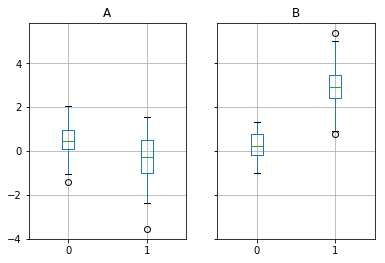

In [49]:
%matplotlib inline
df.groupby('g').boxplot();

***